In [1]:
# IMPORT KNIŽNÍC
from sklearn.preprocessing import StandardScaler #normalizácia dát
import matplotlib.pyplot as plt                  #vizualizácia
import numpy as np                               #násobenie vstupnou maticou
import pandas as pd                              #definovanie datových štruktúr
import tensorflow.compat.v1 as tf                #predikcia
tf.disable_v2_behavior()                         
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# načítanie datasetu
btc = pd.read_csv('BTC-EUR.csv')

# zobrazenie prvých 10 prvkov datasetu (ak neuvedieme parameter 10, defaultne sa vypíše prvých 5 prvkov)
btc.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,359.546204,361.468506,351.586884,355.957367,355.957367,16389165
1,2014-09-18,355.588409,355.505402,319.789459,328.539368,328.539368,26691849
2,2014-09-19,328.278503,330.936707,298.921021,307.761139,307.761139,29560102
3,2014-09-20,307.665253,329.978180,303.931244,318.758972,318.758972,28736825
4,2014-09-21,318.120514,321.504517,306.502197,310.632446,310.632446,20702624
5,2014-09-22,310.849762,316.469116,309.170898,312.958771,312.958771,18776342
6,2014-09-23,312.912079,343.704376,307.343872,339.189758,339.189758,35102350
7,2014-09-24,339.158630,339.307556,327.882263,331.250000,331.250000,23972839
8,2014-09-25,331.211639,331.444672,321.226959,322.676605,322.676605,21022657
9,2014-09-26,322.562897,325.339478,314.102081,318.896851,318.896851,16922252


In [3]:
# použijeme iba 1 stĺpec z datasetu - Close
used_data=btc['Close'].values 

# výpis hodnôt zvoleného stĺpca
used_data 

array([ 355.957367,  328.539368,  307.761139, ..., 8458.521484,
       8436.573242, 8456.394531])

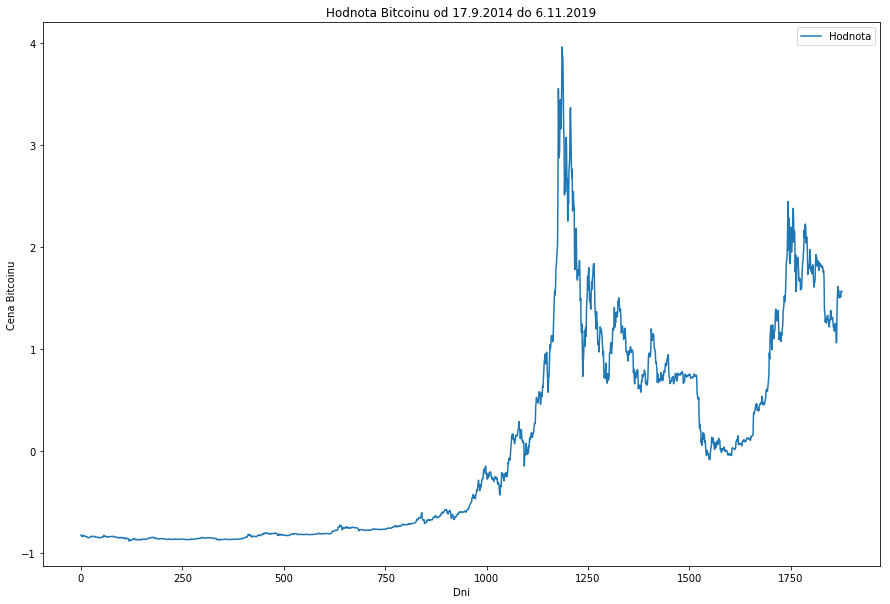

In [4]:
# škálovanie údajov pomocou predvolenej importovanej knižnice StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(used_data.reshape(-1, 1))


# VIZUALIZÁCIA DÁT

# nastavenie grafu - veľkosť
plt.figure(figsize=(15,10))

# nadpis grafu
plt.title('Hodnota Bitcoinu od 17.9.2014 do 6.11.2019')

# popis osi X grafu - počet dní za dané obdobie = 1878 dní
plt.xlabel('Dni')

# popis osi Y grafu - cenové rozpätie Bitcoinu za dané obdobie
plt.ylabel('Cena Bitcoinu')

# popis legendy grafu
plt.plot(scaled_data, label='Hodnota')

# legenda
plt.legend()

# vykreslenie grafu
plt.show()

In [5]:
# VYTVORENIE VLASTNOSTÍ A POPISU DÁT PRE VIZUALIZÁCIU

# data - použitý dátový súbor
# window_size - počet dátových bodov, ktorý sa bude používať na predpovedanie ďalšieho údajového bodu v sekvencii 
# (ak window_size = 1 použije sa len predchádzajúci deň na predpovedanie dnešnej hodnoty)
def window_data(data, window_size):
    
    # Na začiatku nastavené ako prázdne polia
    X = [] 
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        i += 1
    assert len(X) ==  len(y)
    
    # Outputs: X - hodnoty ktoré su rozdelené do okien dátoých bodov(if window_size = 1, X = [len(data)-1, 1])
    # y - 'labels', čislo v sekvenci ktoré sa snažime predpovedat
    return X, y

# Zobrazenie dát pomocou funkcie window_data
X, y = window_data(scaled_data, 7)



In [6]:
# ROZDELENIE DÁT NA TRÉNOVAICE A TESTOVACIE (v pomere 70:30)

# Vstupné trénovacie X = prvých 1315 prvkov datasetu
X_train  = np.array(X[:1315])

# Vstupné trénovacie y = prvých 1315 prvkov datasetu
y_train = np.array(y[:1315])

# Vstupné testovacie X = všetky prvky od 1315. miesta
X_test = np.array(X[1315:])

# Vstupné testovacie y = všetky prvky od 1315. miesta
y_test = np.array(y[1315:])

# Výpis veľkostí vstupných trénovacích a testovacích premenných
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1315, 7, 1)
y_train size: (1315, 1)
X_test size: (555, 7, 1)
y_test size: (555, 1)


In [7]:
# DEFINÍCIA SIETE

# Veľkosť dávky, ktorá sa spracuje naraz
batch_size = 7

# Veľkosť window_size (pomocou kolkých dní chceme predikovať další bod v sekvencii)
window_size = 7

# Koľko jednotiek používame v bunke LSTM
hidden_layer = 256

# Aby sme predišli explozívnemu gradientu, používame clipper na spúšťanie gradientov pod okrajom alebo nad týmto okrajom
clip_margin = 4

# Rýchlosť učenia (kroky)
learning_rate = 0.001

# Počet epoch
epochs = 200

In [8]:
# DEFINÍCA PLACEHOLDERS
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

In [9]:
# LSTM VÁHY PRE JEDNOTLIVÉ BRÁNY

# Váhy pre input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

# Váhy pre forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

# Váhy pre output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

# Váhy pre memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

# Váhy pre output layer
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

In [10]:
# VÝPOČTY STAVOV BRÁN

def LSTM_cell(input, output, state):
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output

In [11]:
# CYKLUS SIETE

# Na začiatku deklarované ako prázdne pole s výstupmi
outputs = [] 

# Iteruje cez každé okno (window) v každej dávke (batch)
for i in range(batch_size): 
  
    # Pre každú dávku (batch) sa vytvara batch_state s nulami a výstup pre toto okno obsahuje tiež od začiatku nuly
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    # Pre každý bod platí, že ho pridávame do LSTM pre získanie ďalšieho výstupu
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
    
    # Posledný výstup sa používa na získanie predikcie
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs # Výpis získaných výstupov

[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_383:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_447:0' shape=(1, 1) dtype=float32>]

In [12]:
#DEFINOVANIE STRÁT

# Na začiatku nie sú straty, preto prázdne pole
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

# Definícia optimalizátora s gradientovým orezaním
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
# TRÉNOVANIE SIETE

session = tf.Session()
session.run(tf.global_variables_initializer())

# Každé opakovanie cyklu predstavuje jednu epochu, celkovo prebehne 200x
for i in range(epochs):
    # Pole s výstupmi trénovania
    trained_scores = [] 
    ii = 0
    # Pole so stratami pre jednotlivé epochy
    epoch_loss = [] 
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        trained_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        
        # Výpis každej 30. epochy spolu so stratami, ku ktorým došlo
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.059277161955833435
Epoch 30/200  Current loss: 0.3074803054332733
Epoch 60/200  Current loss: 0.21699625253677368
Epoch 90/200  Current loss: 0.16982127726078033
Epoch 120/200  Current loss: 0.1371445506811142
Epoch 150/200  Current loss: 0.1106317788362503
Epoch 180/200  Current loss: 0.15354393422603607


In [14]:
# VÝSTUP Z TRÉNOVACÍCH DÁT
sup = []
for i in range(len(trained_scores)):
    for j in range(len(trained_scores[i])):
        sup.append(trained_scores[i][j][0])

In [15]:
# VÝSTUP Z TESTOVACÍCH DÁT

tests = []
i = 0
while i+batch_size <= len(X_test): 
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)
    
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])
        
test_results = []
for i in range(1585): 
    if i >= 1340: 
        test_results.append(tests_new[i-1340])
    else:
        test_results.append(None)

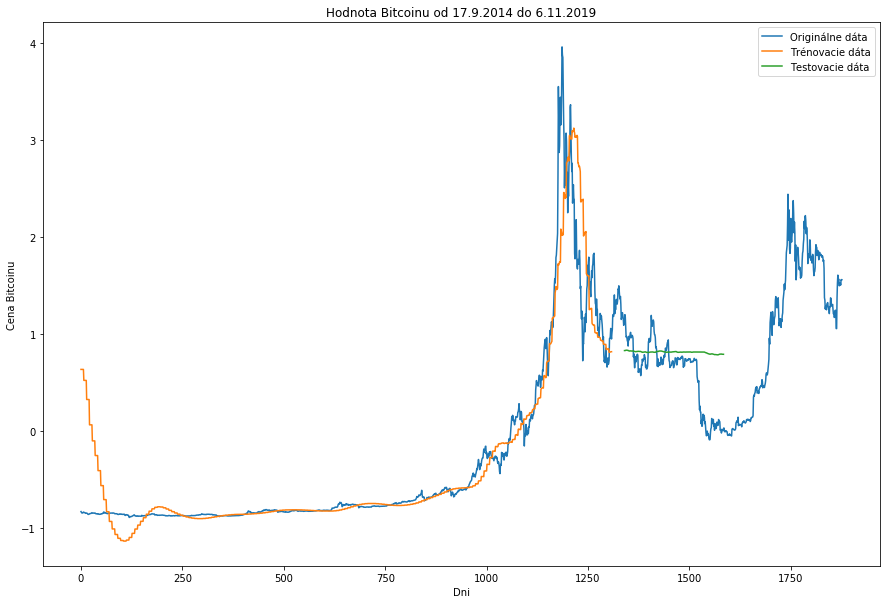

In [16]:
# VYKRESLENIE PREDIKCIE

# nastavenie grafu - veľkosť, farby
plt.figure(figsize=(15, 10))

# nadpis grafu
plt.title('Hodnota Bitcoinu od 17.9.2014 do 6.11.2019')

# popis osi X grafu - počet dní za dané obdobie
plt.xlabel('Dni')

# popis osi Y grafu - cenové rozpätie Bitcoinu za dané obdobie
plt.ylabel('Cena Bitcoinu')

# popis legendy grafu
plt.plot(scaled_data, label='Originálne dáta')
plt.plot(sup, label='Trénovacie dáta')
plt.plot(test_results, label='Testovacie dáta')

# legenda
plt.legend()

# vykreslenie grafu
plt.show()